In [1]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch
from functions import handy_functions as hf

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

2024-05-07 14:36:39.484523: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 14:36:39.522120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 14:36:39.522145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 14:36:39.523076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 14:36:39.529787: I tensorflow/core/platform/cpu_feature_guar

In [2]:
main_dir='/cloud/skogsstyrelsen_1c_attempt_2/'
directories=os.listdir(main_dir)
directories

['0316fae7-d2c1-40b7-b6b1-572503129723',
 '124c5465-43c0-4b8b-a624-f78a237a4a55',
 '307f0810-6f13-4bde-b88c-b9eaf8ce5d25',
 '3b208f65-cf77-4349-9708-a9a4fc06f5d8',
 '3b9b0586-98ce-4603-bd8b-a81423647b70',
 '43ab4c4c-310b-44ae-9548-e09017656537',
 '48948379-d614-4be8-a319-8174a15875e0',
 '5f22ce6c-8d7d-438f-ab05-bd043a708e82',
 '6061d236-faf2-4e6f-83cb-3fdda8451144',
 '68dbadbe-22e8-4839-afa9-b6dbe8331b22',
 '783b6f31-d468-4a86-802d-41b2c8df9bc2',
 '7e2fa848-3d2a-4eb4-99b6-4ffd36a8fb46',
 '866209bc-5ef4-4917-8759-21be697c4fc8',
 '88a26a3d-7ac4-4342-95ed-e630bc7122d0',
 '8ef56cc8-841a-41db-87e7-08c2a41b381c',
 '9eb96d40-6ca4-43b6-863e-f75211c1bfe0',
 '9fd0096b-b3d8-499f-84c1-89e69cc0a743',
 'b8c67bde-8f24-4102-bd11-7893e64070d6',
 'bcfbcb12-8d19-4a50-88fb-d57f847b6943',
 'c5382068-a8ab-40c7-a638-92a14fe493bc',
 'e44bba51-a024-4890-9758-bcf82bde1e98',
 'f3d18472-a865-459b-a5d7-a4cda0d1ce30']

In [3]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model_load_paths=['cot_model_new_surf/0/model_it_2000000','cot_model_new_surf/1/model_it_2000000',
                  'cot_model_new_surf/2/model_it_2000000','cot_model_new_surf/3/model_it_2000000',
                  'cot_model_new_surf/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

#means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
#stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

means=[0.538923,0.530993,0.579427,0.630218,0.759563,0.807696,0.767415,0.839607,0.402664,0.066681,0.442786,0.344600,58.065838]
stds=[0.199267,0.175733,0.179156,0.165408,0.157317,0.157984,0.151002,0.158407,0.232892,0.096684,0.313212,0.220723,15.569941]


In [5]:
tX_mean=torch.tensor([1.2546e-01, 1.0614e-01, 9.0027e-02, 
                      1.2212e-01, 1.9893e-01, 2.2927e-01,
                      2.2877e-01, 2.5855e-01, 8.8865e-02, 
                      2.2552e-03, 1.6460e-01, 9.8362e-02,
                      3.9043e+01, 6.9919e-01], dtype=torch.float, device='cuda:0')

tX_std=torch.tensor([3.9973e-02, 4.0933e-02, 4.8643e-02, 
                     4.9892e-02, 5.9319e-02, 6.6409e-02,
                     6.5552e-02, 7.2190e-02, 3.1435e-02, 
                     1.4109e-03, 6.8219e-02, 5.5329e-02,
                     5.5664e+00, 5.8160e-01], dtype=torch.float, device='cuda:0')

In [6]:
main_filepath='pytorch_models/COT_anton_trans'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))
    
index_median=1

In [7]:
pairs_all=[]
pairs_all_ix=[]
ims_all=[]
cots_all=[]
temporals_all=[]
coords_all=[]
bound_boxs_all=[]
divide=10000
for i,dir in enumerate(directories):
    print('dir '+str(i)+' of '+str(len(directories)))
    pairs=[]
    pairs_ix=[]
    #Get temporals for directory
    temporals_t=glob.glob(main_dir+dir+'/*.nc')
    temporals=[]
    for t in temporals_t:
        temporals.append(t.split('/')[-1].split('.')[0])
    temporals_all.append(temporals)
    ims=[]
    cots=[]
    coords=[]
    bound_box=[]
    for j,temp in enumerate(temporals):
        print('     Temporal '+str(j)+' of '+str(len(temporals)))

        loaded_data = xr.open_dataset(main_dir+dir+'/'+temp+'.nc', engine='netcdf4', decode_times=True)
        nodata = loaded_data.attrs.get("nodata", None)
        loaded_data = loaded_data.where(loaded_data != nodata, np.nan)
        variables=loaded_data.variables


        if int(temp.split('-')[0])>=2022: #Add offset to all data past 2022
            offset=-1000
        else:
            offset=0
        ## Get bands ##
        b02=(np.clip(variables['b02'].data[0,:,:],offset,10000)+offset)/divide
        b03=(np.clip(variables['b03'].data[0,:,:],offset,10000)+offset)/divide
        b04=(np.clip(variables['b04'].data[0,:,:],offset,10000)+offset)/divide
        b05=(np.clip(variables['b05'].data[0,:,:],offset,10000)+offset)/divide
        b06=(np.clip(variables['b06'].data[0,:,:],offset,10000)+offset)/divide
        b07=(np.clip(variables['b07'].data[0,:,:],offset,10000)+offset)/divide
        b08=(np.clip(variables['b08'].data[0,:,:],offset,10000)+offset)/divide
        b8a=(np.clip(variables['b8a'].data[0,:,:],offset,10000)+offset)/divide
        b09=(np.clip(variables['b09'].data[0,:,:],offset,10000)+offset)/divide
        b10=(np.clip(variables['b10'].data[0,:,:],offset,10000)+offset)/divide
        b11=(np.clip(variables['b11'].data[0,:,:],offset,10000)+offset)/divide
        b12=(np.clip(variables['b12'].data[0,:,:],offset,10000)+offset)/divide
        sun_z=variables['sun_zenith']

        ## Save image ##
        im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
        im[:,:,0]=b02
        im[:,:,1]=b03
        im[:,:,2]=b04
        im[:,:,3]=b05
        im[:,:,4]=b06
        im[:,:,5]=b07
        im[:,:,6]=b08
        im[:,:,7]=b8a
        im[:,:,8]=b09
        im[:,:,9]=b10
        im[:,:,10]=b11
        im[:,:,11]=b12
        im[:,:,12]=sun_z


        #Reshape and prepare COT estimation
        im_shape=np.shape(im)
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
        for i in range(im_shape[2]):
            im_cloud_r[:,i]=np.reshape(im[:,:,i],im_shape[0]*im_shape[1])
        
        #COT estimation
        inputs = (im_cloud_r - means) / stds
        image_input_tens=torch.Tensor(inputs).to(device)
        #image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50
        preds = 0
        for model_cot in models_cot:
            curr_preds=model_cot(image_input_tens)/len(models_cot)
            preds=preds+curr_preds
        pred_cot=preds.cpu().data.numpy() #unnormalise
        ## Reshape back
        im_pred_cot=np.reshape(pred_cot,im_shape[0:2])*50
        t_is_cloud = 0.025*50 # From Alex
        t_thin_cloud = 0.019*50 # From Alex
        im_pred_cot_t=im_pred_cot.copy()
        im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
        im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
        im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2

        im_pred_cot_t_r=np.reshape(im_pred_cot_t,im_shape[0]*im_shape[1])
        cots.append(im_pred_cot_t_r)
        im_wcot=np.zeros((im_shape[0],im_shape[1],im_shape[2]+1))
        im_wcot[:,:,0:13]=im
        im_wcot[:,:,13]=im_pred_cot_t
        ims.append(im_wcot)
        coords.append(loaded_data.coords)
        bound_box.append([variables['west'].data,variables['east'].data,variables['north'].data,variables['south'].data])
    
    cloud_cov=0.00001
    for j,cot in enumerate(cots):
        frac_cloud=np.sum(cot>0)/np.size(cot)
        if frac_cloud<=cloud_cov: #If less than cloud_cov*100 % clouds
            if j<(len(cots)-1):
                if np.sum(cots[j+1]>1)/np.size(cots[j+1])<cloud_cov: #If no cloud in neighbouring image
                    pair=(temporals[j+1],temporals[j])
                    pair_ix=(j+1,j)
                    pairs.append(pair)
                    pairs_ix.append(pair_ix)
            elif j>0:
                if np.sum(cots[j-1]>0)/np.size(cots[j-1])<cloud_cov: #If no cloud in neighbouring image
                    pair=(temporals[j-1],temporals[j])
                    pair_ix=(j-1,j)
                    pairs.append(pair)
                    pairs_ix.append(pair_ix)
    pairs_all.append(pairs)
    pairs_all_ix.append(pairs_ix)
    ims_all.append(ims)
    coords_all.append(coords)
    bound_boxs_all.append(bound_box)

dir 0 of 22
     Temporal 0 of 13
     Temporal 1 of 13
     Temporal 2 of 13
     Temporal 3 of 13
     Temporal 4 of 13
     Temporal 5 of 13
     Temporal 6 of 13
     Temporal 7 of 13
     Temporal 8 of 13
     Temporal 9 of 13
     Temporal 10 of 13
     Temporal 11 of 13
     Temporal 12 of 13
dir 1 of 22
     Temporal 0 of 20
     Temporal 1 of 20
     Temporal 2 of 20
     Temporal 3 of 20
     Temporal 4 of 20
     Temporal 5 of 20
     Temporal 6 of 20
     Temporal 7 of 20
     Temporal 8 of 20
     Temporal 9 of 20
     Temporal 10 of 20
     Temporal 11 of 20
     Temporal 12 of 20
     Temporal 13 of 20
     Temporal 14 of 20
     Temporal 15 of 20
     Temporal 16 of 20
     Temporal 17 of 20
     Temporal 18 of 20
     Temporal 19 of 20
dir 2 of 22
     Temporal 0 of 18
     Temporal 1 of 18
     Temporal 2 of 18
     Temporal 3 of 18
     Temporal 4 of 18
     Temporal 5 of 18
     Temporal 6 of 18
     Temporal 7 of 18
     Temporal 8 of 18
     Temporal 9 of 18
     

In [8]:
for i,pairs in enumerate(pairs_all):
    for j,pair in enumerate(pairs):
        print(pair)
        print(pairs_all_ix[i][j])
        

('2022-10-23', '2022-10-18')
(1, 0)
('2022-10-25', '2022-10-23')
(2, 1)
('2023-06-10', '2023-06-07')
(7, 6)
('2023-06-15', '2023-06-10')
(8, 7)
('2023-06-17', '2023-06-15')
(9, 8)
('2022-09-11', '2022-09-06')
(1, 0)
('2022-10-08', '2022-09-21')
(3, 2)
('2023-05-29', '2023-05-19')
(10, 9)
('2023-06-23', '2023-05-29')
(11, 10)
('2023-06-25', '2023-06-23')
(12, 11)
('2023-07-10', '2023-07-08')
(14, 13)
('2023-07-28', '2023-07-10')
(15, 14)
('2023-08-27', '2023-07-28')
(16, 15)
('2023-09-06', '2023-08-27')
(17, 16)
('2023-09-08', '2023-09-06')
(18, 17)
('2022-10-21', '2022-10-18')
(2, 1)
('2022-10-23', '2022-10-21')
(3, 2)
('2023-05-19', '2023-05-14')
(6, 5)
('2023-05-21', '2023-05-19')
(7, 6)
('2023-06-08', '2023-05-21')
(8, 7)
('2023-06-15', '2023-06-08')
(9, 8)
('2023-06-23', '2023-06-15')
(10, 9)
('2023-07-03', '2023-06-23')
(11, 10)
('2023-09-08', '2023-08-29')
(14, 13)
('2023-09-26', '2023-09-08')
(15, 14)
('2023-09-08', '2023-09-26')
(14, 15)
('2020-06-08', '2019-09-22')
(1, 0)
('20

In [9]:
pairs_count=0
for pairs in pairs_all:
    for pair in pairs:
        pairs_count+=1

In [10]:
pairs_count

264

In [11]:
samples=40
np.random.seed(42)
rng=np.random.default_rng(seed=42)
samp_inds=rng.choice(pairs_count, size=samples, replace=False)



In [12]:
pairs_all_new=[]
pairs_all_ix_new=[]
p_c=0
for i,pairs in enumerate(pairs_all):
    pairs_tmp=[]
    pairs_ix_tmp=[]
    for j,pair in enumerate(pairs):

        if np.sum(samp_inds==p_c)>0:
            pairs_tmp.append(pair)
            pairs_ix_tmp.append(pairs_all_ix[i][j])

        p_c+=1
    
    pairs_all_new.append(pairs_tmp)
    pairs_all_ix_new.append(pairs_ix_tmp)


In [13]:
pairs_count=0
for pairs in pairs_all_new:
    for pair in pairs:
        pairs_count+=1

In [14]:
pairs_count

40

In [15]:
pairs_all=pairs_all_new.copy()
pairs_all_ix=pairs_all_ix_new.copy()

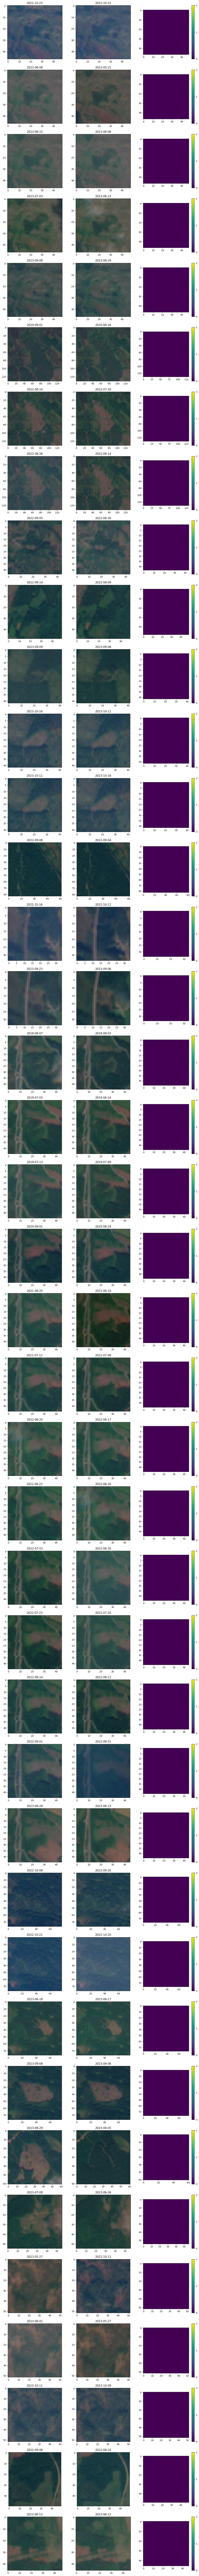

In [16]:
ncols=3
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix[i]

    for j,pair in enumerate(pairs):


        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]

        im_clear_show=hf.Sentinel2TrueColor(im_clear)
        im_cloud_show=hf.Sentinel2TrueColor(im_cloud)

        axs[pair_c,0].imshow(im_clear_show)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(im_cloud_show)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        im_c=axs[pair_c,2].imshow(im_cloud[:,:,-1],vmin=0,vmax=2)
        fig.colorbar(im_c,ax=axs[pair_c,2],ticks=[0,1,2])
        pair_c+=1

In [17]:
#remove_pairs=np.array([0,1,4,10,12,13])
remove_pairs=np.array([0,1,2,3,4,7,10,11,12,14,15,16,20,21,22,23,24,25,26,27,29,30,33,34,35,36,37])
#remove_pairs=np.array([1,5,8,9,11,13,14,15,18,20,22,24,25])

In [18]:
pairs_all_new=[]
pairs_all_ix_new=[]
#Fix Tomorrow
p_c=0
for i,pairs in enumerate(pairs_all):
    pairs_tmp=[]
    pairs_ix_tmp=[]
    for j,pair in enumerate(pairs):

        if np.sum(remove_pairs==p_c)==0:
            pairs_tmp.append(pair)
            pairs_ix_tmp.append(pairs_all_ix[i][j])

        p_c+=1
    
    pairs_all_new.append(pairs_tmp)
    pairs_all_ix_new.append(pairs_ix_tmp)


In [19]:
pairs_count=0
for pairs in pairs_all_new:
    for pair in pairs:
        pairs_count+=1

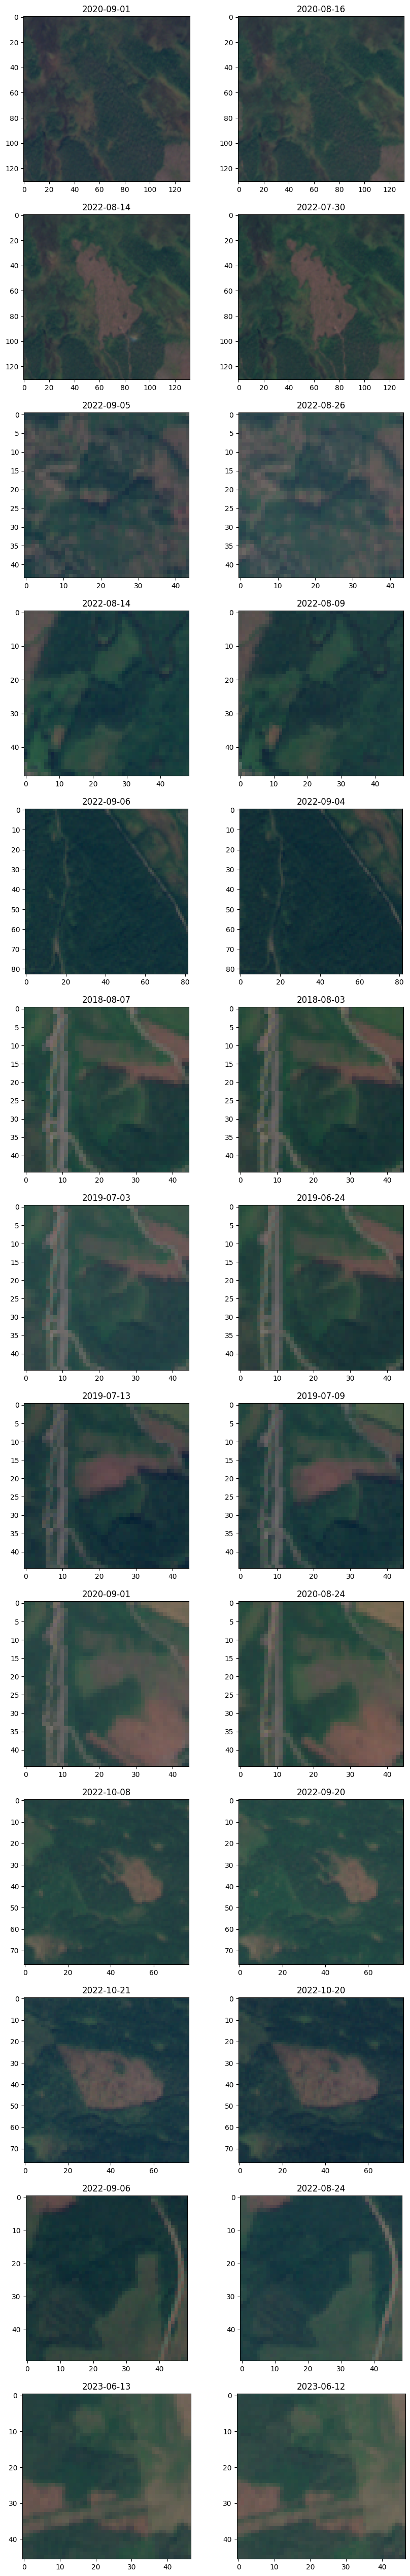

In [20]:
ncols=2
nrows=pairs_count

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,dir in enumerate(directories):
    ims=ims_all[i]
    pairs=pairs_all_ix_new[i]

    for j,pair in enumerate(pairs):


        im_cloud=ims[pairs[j][1]]
        im_clear=ims[pairs[j][0]]

        #New COT
                #Reshape and prepare COT estimation
        im_shape=np.shape(im_cloud)
        im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
        for k in range(im_shape[2]):
            im_cloud_r[:,k]=np.reshape(im_cloud[:,:,k],im_shape[0]*im_shape[1])
        
        #COT estimation
        inputs = (im_cloud_r[:,0:13] - means) / stds
        image_input_tens=torch.Tensor(inputs).to(device)
        #image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50
        preds = 0
        for model_cot in models_cot:
            curr_preds=model_cot(image_input_tens)/len(models_cot)
            preds=preds+curr_preds
        pred_cot=preds.cpu().data.numpy() #unnormalise
        ## Reshape back
        im_pred_cot=np.reshape(pred_cot,im_shape[0:2])*50
        t_is_cloud = 0.025*50 # From Alex
        t_thin_cloud = 0.015*50 # From Alex
        im_pred_cot_t=im_pred_cot.copy()
        im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
        im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
        im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2
        im_pred_cot_t_r=np.reshape(im_pred_cot_t,im_shape[0]*im_shape[1])

        #Set new COT in im_cloud
        #im_cloud[:,:,-1]=im_pred_cot_t
        im_cloud_new=np.zeros((np.shape(im_cloud)[0],np.shape(im_cloud)[1],np.shape(im_cloud)[2]+1))
        im_cloud_new[:,:,0:14]=im_cloud
        im_cloud_new[:,:,13]=im_pred_cot
        im_cloud_new[:,:,-1]=im_pred_cot_t
        ims[pairs[j][1]]=im_cloud_new

        im_clear_show=hf.Sentinel2TrueColor(im_clear)
        im_cloud_show=hf.Sentinel2TrueColor(im_cloud)

        axs[pair_c,0].imshow(im_clear_show)
        axs[pair_c,0].set_title(temporals_all[i][pairs_all_ix[i][j][0]])
        axs[pair_c,1].imshow(im_cloud_show)
        axs[pair_c,1].set_title(temporals_all[i][pairs_all_ix[i][j][1]])
        pair_c+=1

In [21]:
pairs_all_=pairs_all_new
pairs_all_ix=pairs_all_ix_new

In [22]:
xr.Dataset(
    data_vars=dict(variables=(['a','b'],[[1,2],[3,4]])),
           coords=dict(lon=(["x","y"],[[5,6],[8,9]]),
                       lat=(["x","y"],[[5,6],[8,9]])))

<xarray.Dataset> Size: 96B
Dimensions:    (a: 2, b: 2, x: 2, y: 2)
Coordinates:
    lon        (x, y) int64 32B 5 6 8 9
    lat        (x, y) int64 32B 5 6 8 9
Dimensions without coordinates: a, b, x, y
Data variables:
    variables  (a, b) int64 32B 1 2 3 4

In [23]:
p_c=0
for i,pairs in enumerate(pairs_all_new):
    
    for j,pair in enumerate(pairs):
        ix=pairs_all_ix[i][j]
        im_clear=ims_all[i][ix[0]]
        im_cloud=ims_all[i][ix[1]]
        coords_clear=coords_all[i][ix[0]]
        coords_cloud=coords_all[i][ix[1]]
        box_clear=bound_boxs_all[i][ix[0]]
        box_cloud=bound_boxs_all[i][ix[1]]

        clear_dataset=xr.Dataset(
            data_vars=dict(b02=(['y','x'],im_clear[:,:,0]),
                        b03=(['y','x'],im_clear[:,:,1]),
                        b04=(['y','x'],im_clear[:,:,2]),
                        b05=(['y','x'],im_clear[:,:,3]),
                        b06=(['y','x'],im_clear[:,:,4]),
                        b07=(['y','x'],im_clear[:,:,5]),
                        b08=(['y','x'],im_clear[:,:,6]),
                        b8a=(['y','x'],im_clear[:,:,7]),
                        b09=(['y','x'],im_clear[:,:,8]),
                        b10=(['y','x'],im_clear[:,:,9]),
                        b11=(['y','x'],im_clear[:,:,10]),
                        b12=(['y','x'],im_clear[:,:,11]),
                        sun_zenith_angle=(['y','x'],im_clear[:,:,12]),
                        cloud_mask=(['y','x'],im_clear[:,:,13]),
                        west=box_clear[0],
                        east=box_clear[1],
                        north=box_clear[2],
                        south=box_clear[3]),
                coords=dict(y=(["y"],coords_clear['y'].data),
                            x=(["x"],coords_clear['x'].data),
                            t=(["t"],coords_clear['t'].data)))
        cloudy_dataset=xr.Dataset(
            data_vars=dict(b02=(['y','x'],im_cloud[:,:,0]),
                        b03=(['y','x'],im_cloud[:,:,1]),
                        b04=(['y','x'],im_cloud[:,:,2]),
                        b05=(['y','x'],im_cloud[:,:,3]),
                        b06=(['y','x'],im_cloud[:,:,4]),
                        b07=(['y','x'],im_cloud[:,:,5]),
                        b08=(['y','x'],im_cloud[:,:,6]),
                        b8a=(['y','x'],im_cloud[:,:,7]),
                        b09=(['y','x'],im_cloud[:,:,8]),
                        b10=(['y','x'],im_cloud[:,:,9]),
                        b11=(['y','x'],im_cloud[:,:,10]),
                        b12=(['y','x'],im_cloud[:,:,11]),
                        sun_zenith_angle=(['y','x'],im_cloud[:,:,12]),
                        cloud_mask=(['y','x'],im_cloud[:,:,13]),
                        west=box_cloud[0],
                        east=box_cloud[1],
                        north=box_cloud[2],
                        south=box_cloud[3]),
                coords=dict(y=(["y"],coords_cloud['y'].data),
                            x=(["x"],coords_cloud['x'].data),
                            t=(["t"],coords_cloud['t'].data)))

        os.mkdir('/cloud/skogsstyrelsen_pairs_clear/pair_'+str(p_c))
        clear_dataset.to_netcdf('/cloud/skogsstyrelsen_pairs_clear/pair_'+str(p_c)+'/clear_data.nc',mode='w')
        cloudy_dataset.to_netcdf('/cloud/skogsstyrelsen_pairs_clear/pair_'+str(p_c)+'/cloudy_data.nc',mode='w')
        print('Saved pair '+str(p_c))
        p_c=p_c+1

Saved pair 0
Saved pair 1
Saved pair 2
Saved pair 3
Saved pair 4
Saved pair 5
Saved pair 6
Saved pair 7
Saved pair 8
Saved pair 9
Saved pair 10
Saved pair 11
Saved pair 12


In [24]:
np.shape(im_clear)

(46, 47, 14)

In [25]:
len(coords_clear['x'])

47

In [26]:
loaded_data

<xarray.Dataset> Size: 208kB
Dimensions:      (t: 1, y: 46, x: 47)
Coordinates:
  * t            (t) datetime64[ns] 8B 2023-09-06T10:26:01.024000
  * y            (y) float64 368B 6.7e+06 6.7e+06 ... 6.699e+06 6.699e+06
  * x            (x) float64 376B 6.068e+05 6.068e+05 ... 6.073e+05 6.073e+05
    spatial_ref  int32 4B 3006
Data variables: (12/17)
    b02          (t, y, x) float64 17kB 1.804e+03 1.8e+03 ... 1.764e+03
    b03          (t, y, x) float64 17kB 1.625e+03 1.609e+03 ... 1.54e+03
    b04          (t, y, x) float64 17kB 1.425e+03 1.36e+03 ... 1.335e+03
    b05          (t, y, x) float64 17kB 1.677e+03 1.677e+03 ... 1.546e+03
    b06          (t, y, x) float64 17kB 2.441e+03 2.441e+03 ... 2.208e+03
    b07          (t, y, x) float64 17kB 2.747e+03 2.747e+03 ... 2.435e+03
    ...           ...
    b12          (t, y, x) float64 17kB 1.391e+03 1.391e+03 ... 1.295e+03
    west         float64 8B 16.94
    east         float64 8B 16.95
    north        float64 8B 60.42
    south        float64 8B 60.42
    sun_zenith   float64 8B 37.92
Attributes:
    crs:                EPSG:3006
    nodata:             -9999
    collection:         s2_msi_l1c
    datetime_from_dim:  2024-04-08T13:33:23.208612

## Load new saved data

In [27]:
main_dir='/cloud/skogsstyrelsen_pairs/'
directories=os.listdir(main_dir)
#directories

In [28]:
ims_all=[]
for dir in directories:
    data_clear=xr.load_dataset(main_dir+dir+'/clear_data.nc', engine='netcdf4', decode_times=True)
    data_cloudy=xr.load_dataset(main_dir+dir+'/cloudy_data.nc', engine='netcdf4', decode_times=True)

    variables=data_clear.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b02'].data
    b04=variables['b02'].data
    b05=variables['b02'].data
    b06=variables['b02'].data
    b07=variables['b02'].data
    b08=variables['b02'].data
    b8a=variables['b02'].data
    b09=variables['b02'].data
    b10=variables['b02'].data
    b11=variables['b02'].data
    b12=variables['b02'].data
    sun_z=variables['sun_zenith_angle']
    c_mask=variables['cloud_mask']

    ## Save image ##
    im_clear=np.zeros((np.shape(b03)[0],np.shape(b03)[1],14))
    im_clear[:,:,0]=b02
    im_clear[:,:,1]=b03
    im_clear[:,:,2]=b04
    im_clear[:,:,3]=b05
    im_clear[:,:,4]=b06
    im_clear[:,:,5]=b07
    im_clear[:,:,6]=b08
    im_clear[:,:,7]=b8a
    im_clear[:,:,8]=b09
    im_clear[:,:,9]=b10
    im_clear[:,:,10]=b11
    im_clear[:,:,11]=b12
    im_clear[:,:,12]=sun_z
    im_clear[:,:,13]=c_mask

    variables=data_cloudy.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b02'].data
    b04=variables['b02'].data
    b05=variables['b02'].data
    b06=variables['b02'].data
    b07=variables['b02'].data
    b08=variables['b02'].data
    b8a=variables['b02'].data
    b09=variables['b02'].data
    b10=variables['b02'].data
    b11=variables['b02'].data
    b12=variables['b02'].data
    sun_z=variables['sun_zenith_angle']
    c_mask=variables['cloud_mask']

    ## Save image ##
    im_cloudy=np.zeros((np.shape(b03)[0],np.shape(b03)[1],14))
    im_cloudy[:,:,0]=b02
    im_cloudy[:,:,1]=b03
    im_cloudy[:,:,2]=b04
    im_cloudy[:,:,3]=b05
    im_cloudy[:,:,4]=b06
    im_cloudy[:,:,5]=b07
    im_cloudy[:,:,6]=b08
    im_cloudy[:,:,7]=b8a
    im_cloudy[:,:,8]=b09
    im_cloudy[:,:,9]=b10
    im_cloudy[:,:,10]=b11
    im_cloudy[:,:,11]=b12
    im_cloudy[:,:,12]=sun_z
    im_cloudy[:,:,13]=c_mask

    im_pair=[im_clear,im_cloud]
    ims_all.append(im_pair)